# 1. Imports, setup and loading data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from datetime import datetime

from sklearn.impute import KNNImputer
import plotly.express as px

from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from yellowbrick.cluster import KElbowVisualizer


sns.set_theme(color_codes=True)
pd.set_option('display.max_columns', None)

import warnings
warnings.filterwarnings('ignore')

pd.options.display.float_format = "{:.2f}".format

In [2]:
# Loading data
marketing_df = pd.read_csv('../data/marketing_campaign_data.csv', sep='\t')
marketing_df.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.00,0,0,04-09-2012,58,635,88,546,172,88,88,3,8,10,4,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.00,1,1,08-03-2014,38,11,1,6,2,1,6,2,1,1,2,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.00,0,0,21-08-2013,26,426,49,127,111,21,42,1,8,2,10,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.00,1,0,10-02-2014,26,11,4,20,10,3,5,2,2,0,4,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.00,1,0,19-01-2014,94,173,43,118,46,27,15,5,5,3,6,5,0,0,0,0,0,0,3,11,0


---

# 2. Data Preprocessing

## 2.1. Dataset Overview and Structure

In [3]:
# Shape of dataframe
marketing_df_shape = marketing_df.shape

print("Marketing DataFrame measures:")
print(f"- Number of rows: {marketing_df_shape[0]}")
print(f"- Number of columns: {marketing_df_shape[1]}")

Marketing DataFrame measures:
- Number of rows: 2240
- Number of columns: 29


In [4]:
# Columns and dtypes
marketing_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   2240 non-null   int64  
 1   Year_Birth           2240 non-null   int64  
 2   Education            2240 non-null   object 
 3   Marital_Status       2240 non-null   object 
 4   Income               2216 non-null   float64
 5   Kidhome              2240 non-null   int64  
 6   Teenhome             2240 non-null   int64  
 7   Dt_Customer          2240 non-null   object 
 8   Recency              2240 non-null   int64  
 9   MntWines             2240 non-null   int64  
 10  MntFruits            2240 non-null   int64  
 11  MntMeatProducts      2240 non-null   int64  
 12  MntFishProducts      2240 non-null   int64  
 13  MntSweetProducts     2240 non-null   int64  
 14  MntGoldProds         2240 non-null   int64  
 15  NumDealsPurchases    2240 non-null   i

In [5]:
# Columns with missing data or null values
columns_with_missing_data = marketing_df.columns[marketing_df.isnull().sum() > 0]

print("Columns with missing data or null values:")
print(columns_with_missing_data.tolist())

Columns with missing data or null values:
['Income']


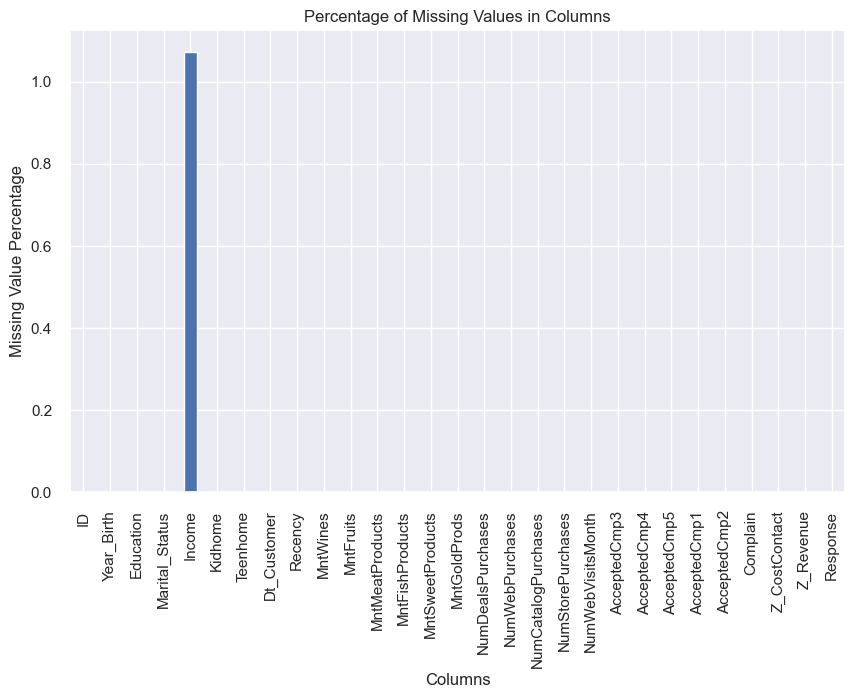

In [6]:
# Calculate the percentage of missing values for each column
missing_percentage = (marketing_df.isnull().sum() / len(marketing_df)) * 100

plt.figure(figsize=(10, 6))
missing_percentage.plot(kind="bar")

plt.xlabel("Columns")
plt.ylabel("Missing Value Percentage")
plt.title("Percentage of Missing Values in Columns")

plt.show()

In [7]:
# Check columns types 
cat_columns = marketing_df.select_dtypes(include=['object']).columns
num_columns = marketing_df.select_dtypes(include=['int64', 'float64']).columns

print(f"Categorical Columns - {len(cat_columns)}:")
print(cat_columns.tolist())
print()
print(f"Numerical Columns - {len(num_columns)}:")
print(num_columns.tolist())

Categorical Columns - 3:
['Education', 'Marital_Status', 'Dt_Customer']

Numerical Columns - 26:
['ID', 'Year_Birth', 'Income', 'Kidhome', 'Teenhome', 'Recency', 'MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds', 'NumDealsPurchases', 'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1', 'AcceptedCmp2', 'Complain', 'Z_CostContact', 'Z_Revenue', 'Response']


In [8]:
marketing_df.duplicated().sum()

0

In [9]:
# Nr of unique values for categorical columns 
marketing_df.select_dtypes('object').nunique()

Education           5
Marital_Status      8
Dt_Customer       663
dtype: int64

In [10]:
# Display unique values for 'Education'
marketing_df['Education'].value_counts()

Education
Graduation    1127
PhD            486
Master         370
2n Cycle       203
Basic           54
Name: count, dtype: int64

In [11]:
# Display unique values for 'Marital_Status'
marketing_df['Marital_Status'].value_counts()

Marital_Status
Married     864
Together    580
Single      480
Divorced    232
Widow        77
Alone         3
Absurd        2
YOLO          2
Name: count, dtype: int64

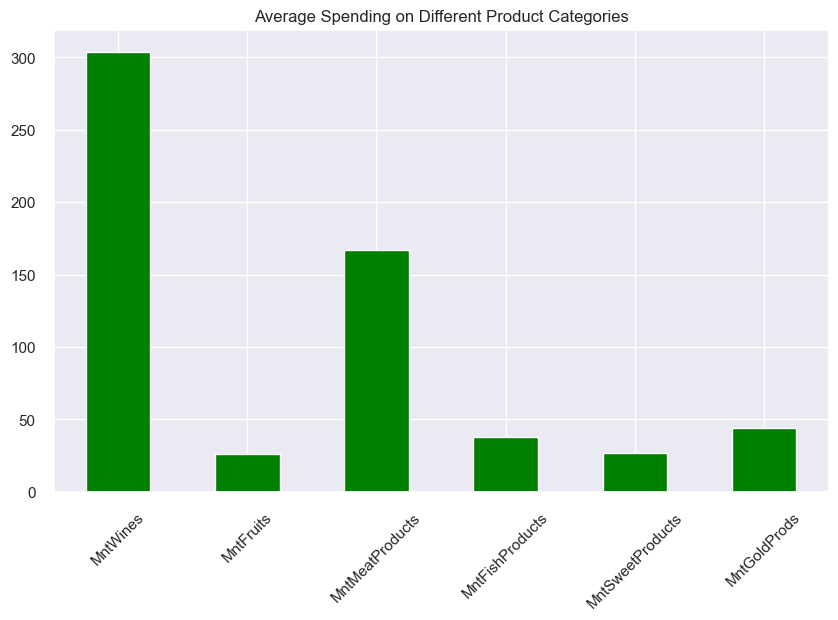

In [12]:
# Spending on different product categories
spending_columns = ["MntWines", "MntFruits", "MntMeatProducts", "MntFishProducts", "MntSweetProducts", "MntGoldProds"]
spending_data = marketing_df[spending_columns].mean()

plt.figure(figsize=(10, 6))
spending_data.plot(kind="bar", color='green')

plt.title("Average Spending on Different Product Categories")
plt.xticks(rotation=45)

plt.show()

## 2.2. Feature Engineering

In [13]:
# Transform "Dt_Customer" dtype from object to datetime
marketing_df['Dt_Customer'] = pd.to_datetime(marketing_df['Dt_Customer'], format='%d-%m-%Y')

In [14]:
# Create the "Age" feature by subtracting "Year_Birth" from the current year 
marketing_df['Age'] = datetime.now().year - marketing_df['Year_Birth']

In [15]:
# Create the "Days_Customer" feature by calculating the number of years since joining
marketing_df['Days_Customer'] = (datetime.now() - marketing_df['Dt_Customer'])
marketing_df['Days_Customer'] = marketing_df['Days_Customer'].dt.days

In [16]:
# Create "Purchases" feature as total purchases
purchases_columns = ['NumDealsPurchases', 'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases']
marketing_df['Total_Purchases'] = marketing_df[purchases_columns].sum(axis=1)

In [17]:
# Create "Age_Group" feature
bins = [0, 2, 4, 12, 19, 39, 59, float('inf')]
labels = ['Infant', 'Toddler', 'Child', 'Teen', 'Adult', 'Middle Aged', 'Senior']
marketing_df['Age_Group'] = pd.cut(marketing_df['Age'], bins=bins, labels=labels, right=True)

In [18]:
# Create the "Spending" feature as the sum of spending on product categories
product_columns = ['MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds']
marketing_df['Total_Spending'] = marketing_df[product_columns].sum(axis=1)

In [19]:
# Create the "Has_child" feature as binary
# marketing_df['Has_Child'] = (marketing_df['Kidhome'] >= 1) | (marketing_df['Teenhome'] >= 1)
# marketing_df['Has_Child'] = marketing_df['Has_Child'].astype(int)

In [20]:
# Create the "Total_Children" feature as binary
marketing_df['Total_Children'] = marketing_df['Kidhome'] + marketing_df['Teenhome']

In [21]:
# Remove inconsistent values 
valid_marital_statuses = ['Married', 'Together', 'Single', 'Divorced', 'Widow', 'Alone']
marketing_df = marketing_df[marketing_df['Marital_Status'].isin(valid_marital_statuses)]

# Consolidate values in 'Marital_Status'
marital_mapping = {'Married': 'In_Couple', 'Together': 'In_Couple', 'Single': 'Alone', 'Divorced': 'Alone', 'Widow': 'Alone', 'Alone': 'Alone'}
marketing_df['Marital_Situation'] = marketing_df['Marital_Status'].map(marital_mapping)

In [22]:
# Create the "In_Couple" binary numerical feature
marketing_df['In_Couple'] = (marketing_df['Marital_Status'].isin(['Married', 'Together'])).astype(int)

In [23]:
# Create "Conversion_Rate" feature
marketing_df['Conversion_Rate']  = np.where(marketing_df['NumWebVisitsMonth'] == 0, 
                                             0, (marketing_df['Total_Purchases'] / marketing_df['NumWebVisitsMonth']))

In [24]:
# Create the "Accepted_Campaigns" feature as the sum of accepted campains
accepted_cmp_columns = ['AcceptedCmp3',	'AcceptedCmp4',	'AcceptedCmp5',	'AcceptedCmp1',	'AcceptedCmp2']
marketing_df['Total_AccCamp'] = marketing_df[accepted_cmp_columns].sum(axis=1)

In [25]:
# Drop columns
marketing_df.drop(columns=product_columns+purchases_columns+accepted_cmp_columns, inplace=True)
marketing_df.drop(columns=['Marital_Status', 'Kidhome', 'Teenhome', 'Year_Birth', 'Z_Revenue', 'Z_CostContact', 'Complain', 'Response'], inplace=True)

In [26]:
# ReCheck columns types 
cat_columns = marketing_df.select_dtypes(include=['object']).columns
num_columns = marketing_df.select_dtypes(include=['int64', 'float64']).columns

print(f"Categorical Columns - {len(cat_columns)}:")
print(cat_columns.tolist())
print()
print(f"Numerical Columns - {len(num_columns)}:")
print(num_columns.tolist())

Categorical Columns - 2:
['Education', 'Marital_Situation']

Numerical Columns - 11:
['ID', 'Income', 'Recency', 'NumWebVisitsMonth', 'Age', 'Days_Customer', 'Total_Purchases', 'Total_Spending', 'Total_Children', 'Conversion_Rate', 'Total_AccCamp']


## 2.3. Statistical summary

In [27]:
#  Check some features statistics
marketing_df.describe()

,ID,Income,Dt_Customer,Recency,NumWebVisitsMonth,Age,Days_Customer,Total_Purchases,Total_Spending,Total_Children,In_Couple,Conversion_Rate,Total_AccCamp
count,2236.00,2212.00,2236,2236.00,2236.00,2236.00,2236.00,2236.00,2236.00,2236.00,2236.00,2236.00,2236.00
mean,5591.55,52232.51,2013-07-10 15:56:21.037566976,49.15,5.32,54.20,3693.34,14.85,605.44,0.95,0.65,4.39,0.30
min,0.00,1730.00,2012-07-30 00:00:00,0.00,0.00,27.00,3340.00,0.00,5.00,0.00,0.00,0.00,0.00
25%,2828.25,35233.50,2013-01-17 00:00:00,24.00,3.00,46.00,3520.75,8.00,68.00,0.00,0.00,1.22,0.00
50%,5458.50,51381.50,2013-07-09 00:00:00,49.00,6.00,53.00,3695.00,15.00,395.50,1.00,1.00,2.60,0.00
75%,8427.75,68522.00,2013-12-30 06:00:00,74.00,7.00,64.00,3868.00,21.00,1044.25,1.00,1.00,5.33,0.00
max,11191.00,666666.00,2014-06-29 00:00:00,99.00,20.00,130.00,4039.00,44.00,2525.00,3.00,1.00,43.00,4.00
std,3245.24,25187.46,NaN,28.95,2.42,11.98,202.06,7.68,602.51,0.75,0.48,4.90,0.68


- The average customer "Age" is around 54, with some extreme values suggesting potential outliers. The maximum reported age of 130 might be an outlier or data entry error, as it's unusually high.
- "Income" levels vary, but there are instances of unusually high incomes.The maximum reported income of 666666 seems like an outlier.
- The "Spending" values show variability, with some customers spending very little (e.g., minimum spending of 5) and others spending significantly more (e.g., maximum spending of 2525).

<Figure size 1000x800 with 0 Axes>

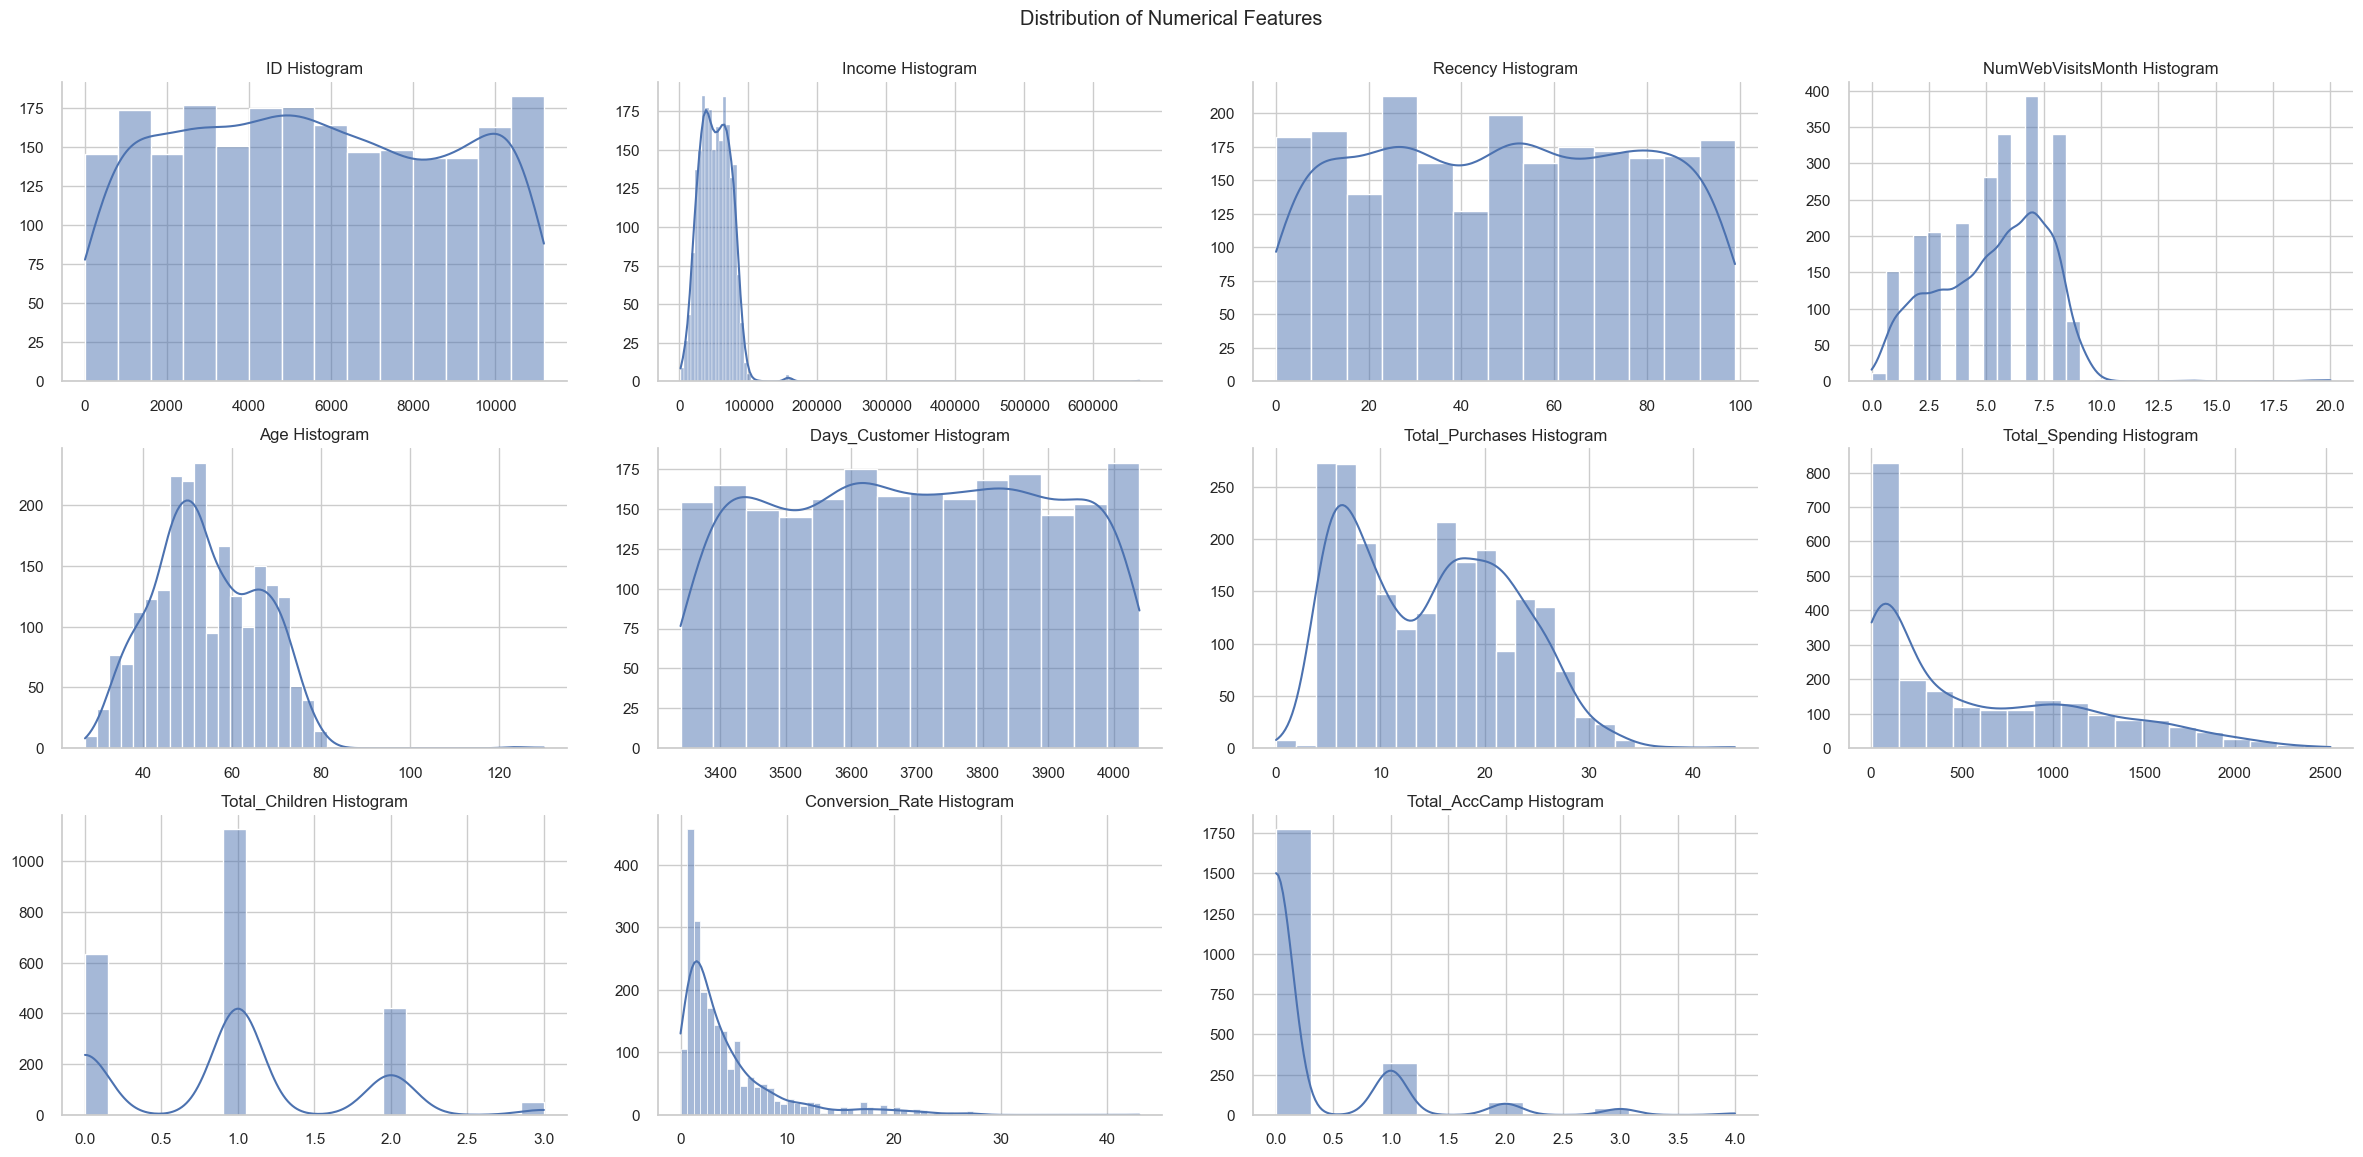

In [28]:
sns.set(style="whitegrid")

plt.figure(figsize=(10, 8))

fig = sns.FacetGrid(marketing_df[num_columns].melt(), col='variable', col_wrap=4, sharex=False, sharey=False, height=4, aspect=1.5)
fig.map(sns.histplot, 'value', kde=True)

fig.set_titles(col_template="{col_name} Histogram")
fig.set_axis_labels("", "")

plt.subplots_adjust(top=0.92)
fig.fig.suptitle("Distribution of Numerical Features")

plt.show()

In [29]:
# Drop Outliers in Income and Age
print(f'Total rows before delete outlier: {len(marketing_df)}')

marketing_df = marketing_df.drop(marketing_df[marketing_df['Income']> 500000].index).reset_index(drop=True)
marketing_df = marketing_df.drop(marketing_df[marketing_df['Age']> 100].index).reset_index(drop=True)

print(f'Total rows after delete outlier: {len(marketing_df)}')

Total rows before delete outlier: 2236
Total rows after delete outlier: 2232


In [30]:
print(f'Missing data or null values in Income column: {marketing_df["Income"].isnull().sum()}')

imputer = KNNImputer(n_neighbors=5, metric='nan_euclidean')

# Fit
imputer.fit(marketing_df[['Income', 'Age']])

# Transform
X = imputer.transform(marketing_df[['Income','Age']])
Income_impute = pd.DataFrame(X, columns=['Income','Age'])
marketing_df['Income'] = Income_impute['Income'].reset_index(drop=True)

print(f'Missing data or null values in Income column after imputing: {marketing_df["Income"].isnull().sum()}')

Missing data or null values in Income column: 24
Missing data or null values in Income column after imputing: 0


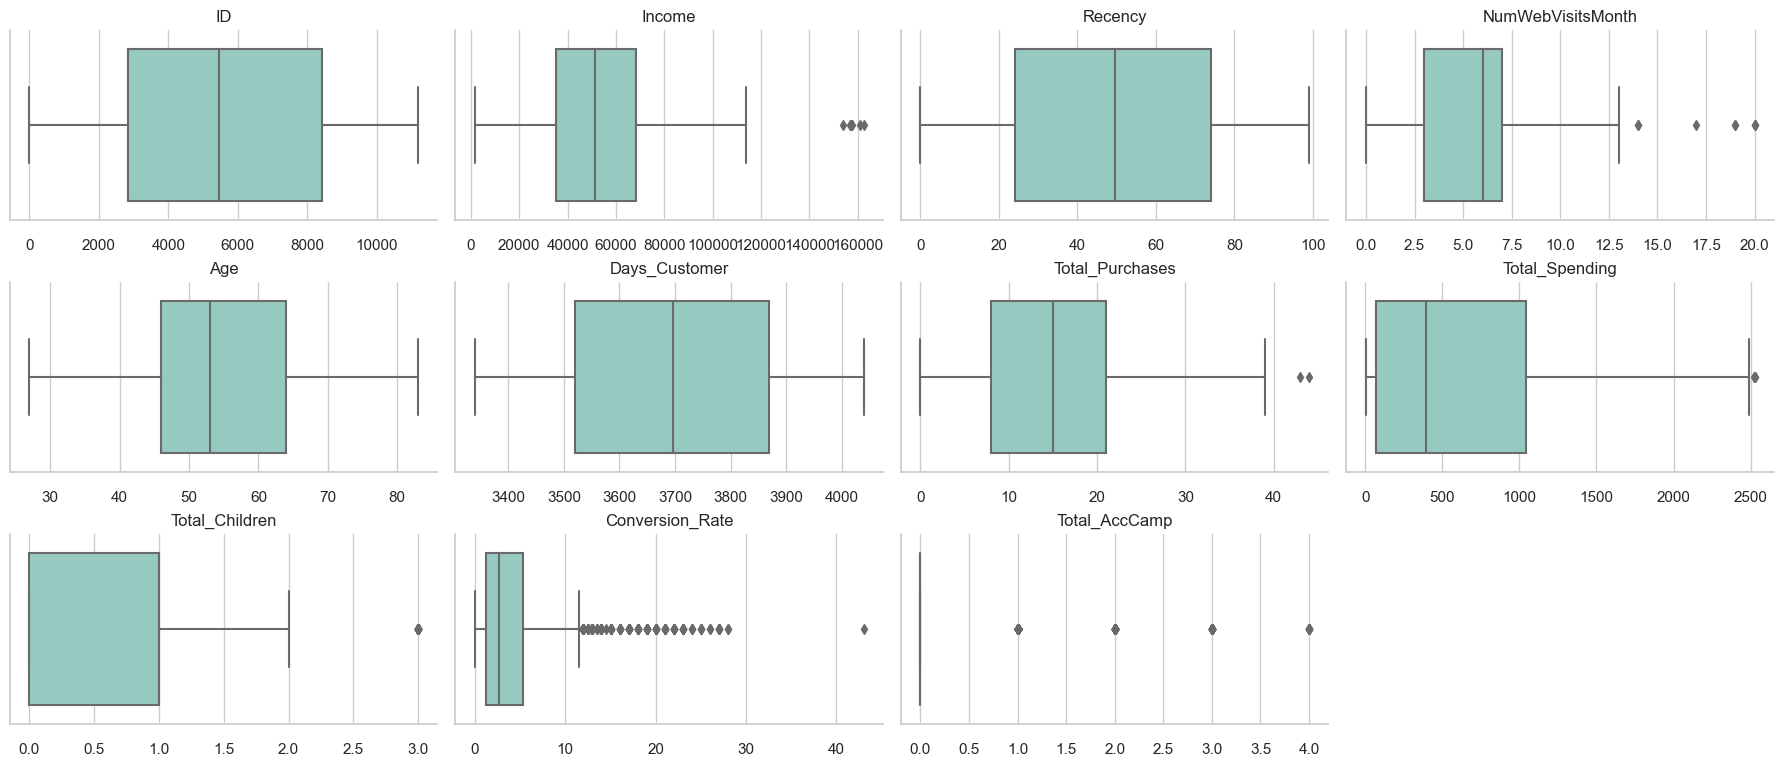

In [31]:
fig = sns.FacetGrid(marketing_df[num_columns].melt(), col='variable', col_wrap=4, sharex=False, sharey=False, height=3, aspect=1.5)
fig.map(sns.boxplot,  'value', palette="Set3")

fig.set_titles(col_template="{col_name}")
fig.set_axis_labels("", "")

plt.subplots_adjust(top=0.85)

plt.show()

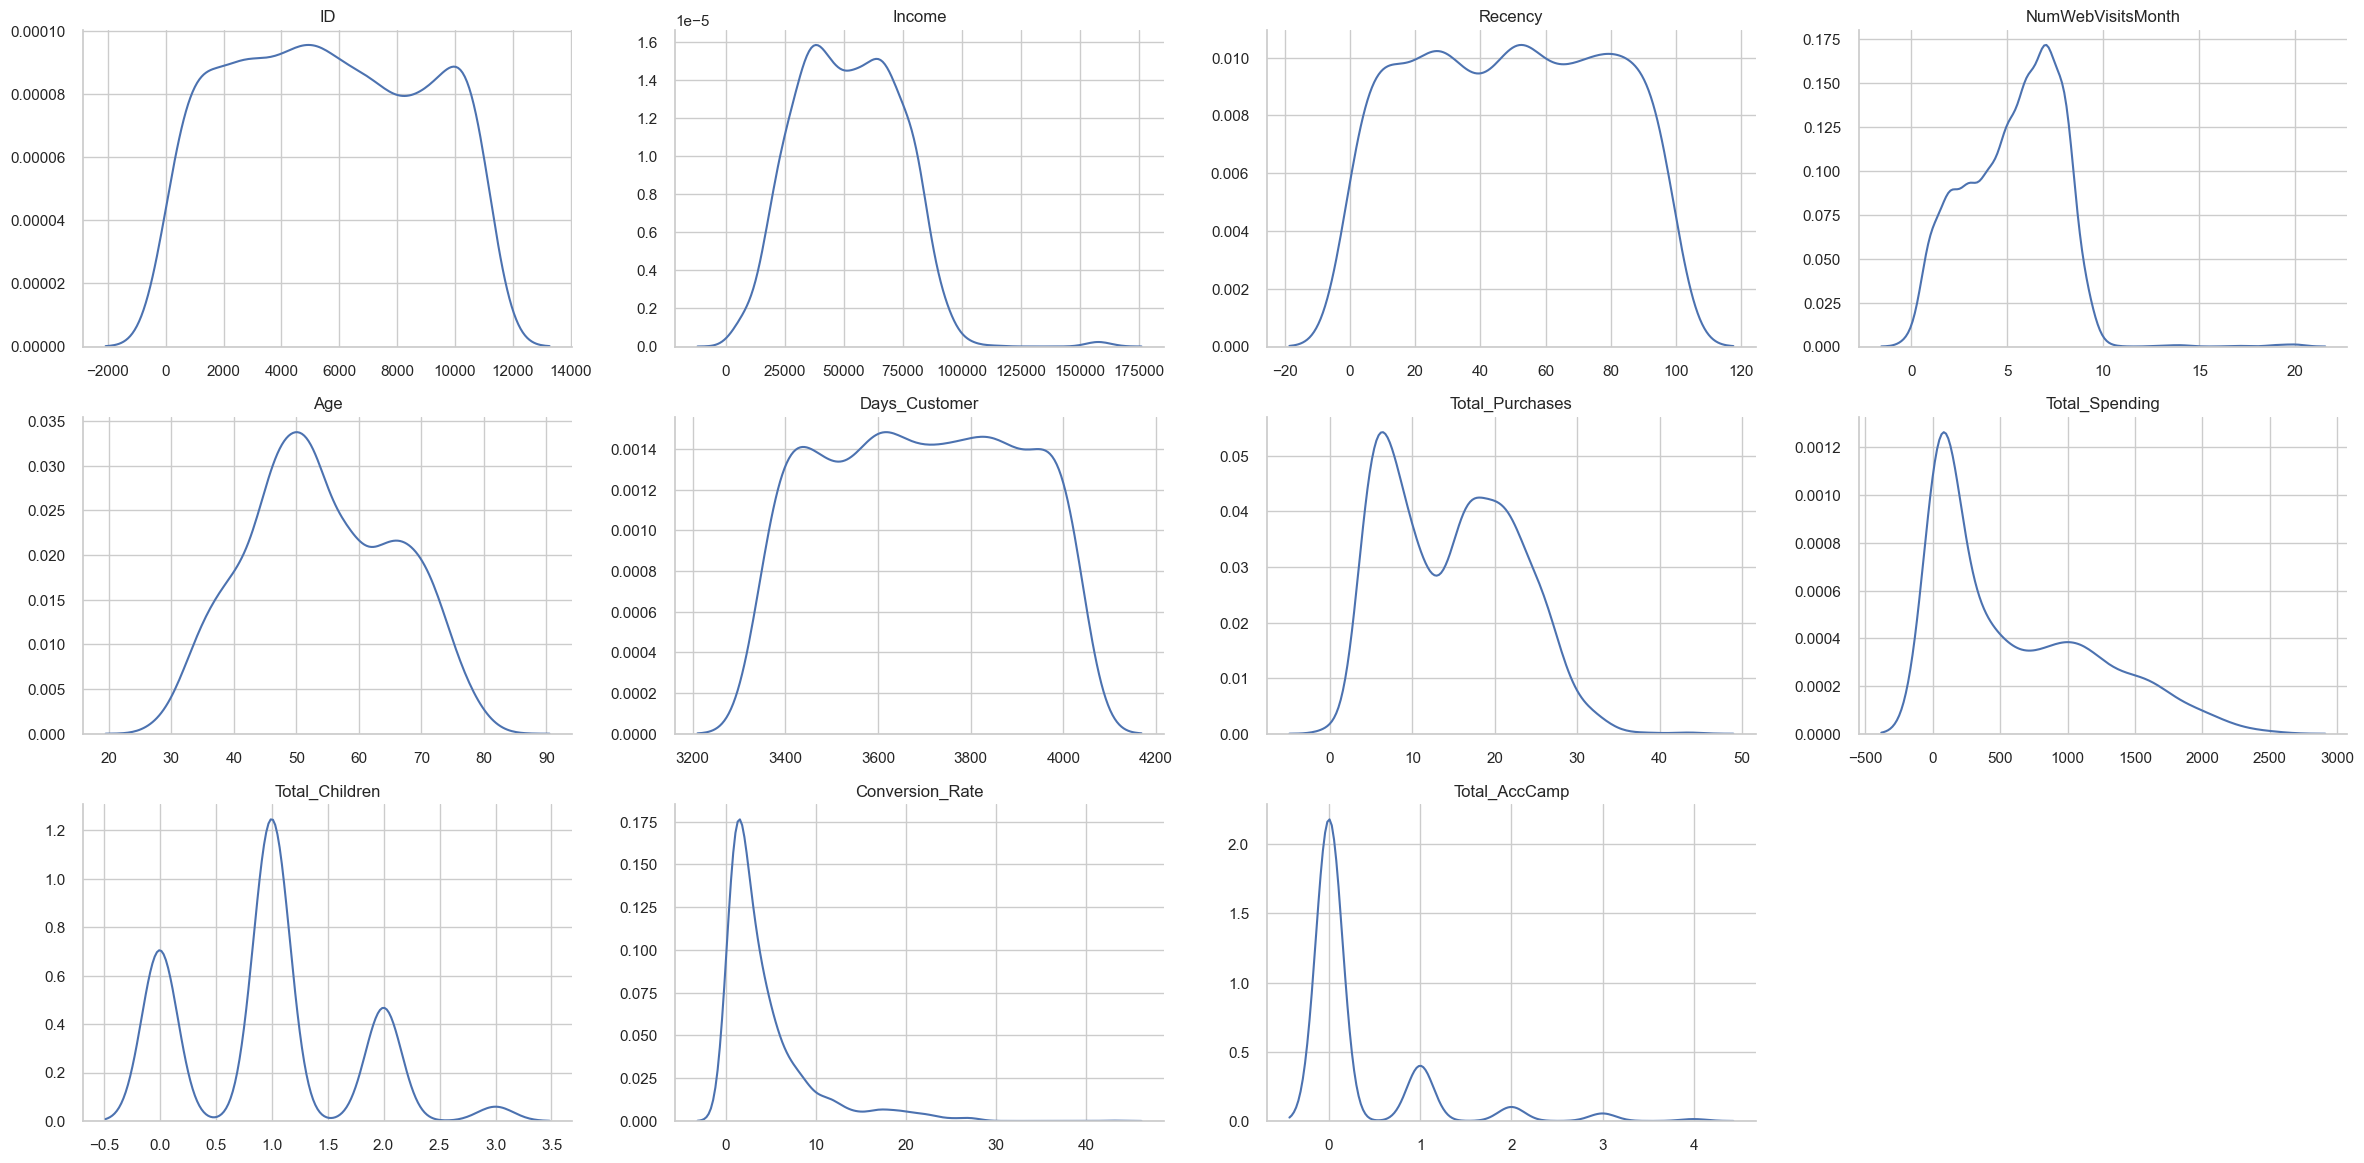

In [32]:
fig = sns.FacetGrid(marketing_df[num_columns].melt(), col='variable', col_wrap=4, sharex=False, sharey=False, height=4, aspect=1.5)
fig.map(sns.kdeplot, 'value')

fig.set_titles(col_template="{col_name}")
fig.set_axis_labels("", "")

plt.show()

In [33]:
marketing_df.describe()

,ID,Income,Dt_Customer,Recency,NumWebVisitsMonth,Age,Days_Customer,Total_Purchases,Total_Spending,Total_Children,In_Couple,Conversion_Rate,Total_AccCamp
count,2232.00,2232.00,2232,2232.00,2232.00,2232.00,2232.00,2232.00,2232.00,2232.00,2232.00,2232.00,2232.00
mean,5588.39,51952.89,2013-07-10 11:21:17.419354880,49.15,5.32,54.11,3693.53,14.86,605.62,0.95,0.65,4.39,0.30
min,0.00,1730.00,2012-07-30 00:00:00,0.00,0.00,27.00,3340.00,0.00,5.00,0.00,0.00,0.00,0.00
25%,2828.25,35376.00,2013-01-16 18:00:00,24.00,3.00,46.00,3520.75,8.00,69.00,0.00,0.00,1.22,0.00
50%,5454.50,51445.50,2013-07-08 12:00:00,49.50,6.00,53.00,3695.50,15.00,396.00,1.00,1.00,2.61,0.00
75%,8421.75,68275.75,2013-12-30 06:00:00,74.00,7.00,64.00,3868.25,21.00,1044.25,1.00,1.00,5.33,0.00
max,11191.00,162397.00,2014-06-29 00:00:00,99.00,20.00,83.00,4039.00,44.00,2525.00,3.00,1.00,43.00,4.00
std,3243.40,21444.07,NaN,28.95,2.42,11.70,202.12,7.68,602.12,0.75,0.48,4.90,0.68


# 3. Visual Exploratory Data Analysis

## 3.1 Income by Education

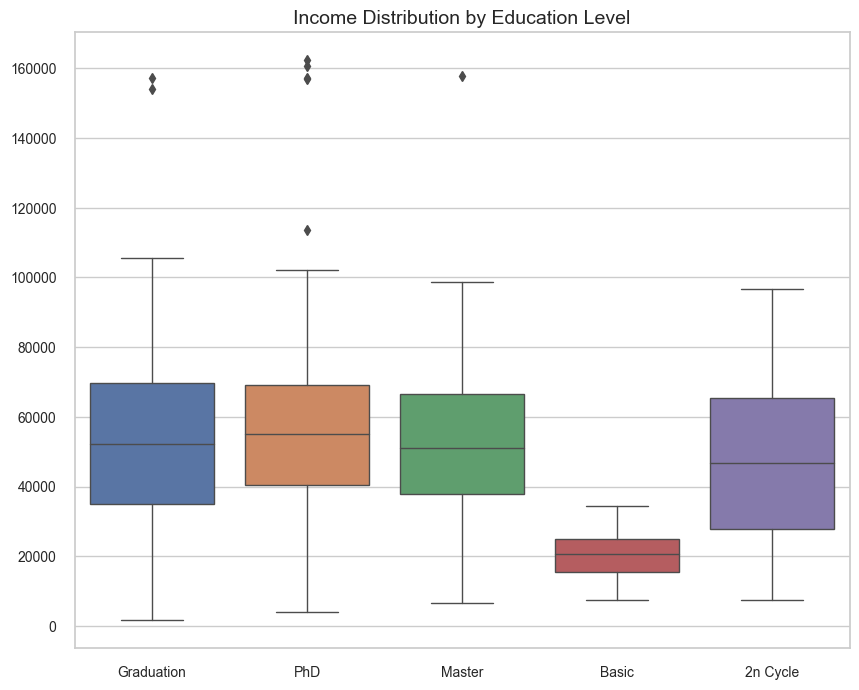

In [34]:
plt.figure(figsize=(10, 8))
sns.boxplot(data=marketing_df, x='Education', y='Income', linewidth=1) 

plt.xlabel("")
plt.ylabel("")
plt.title("Income Distribution by Education Level", fontsize=14)

plt.tick_params(axis='y', labelsize=10)
plt.tick_params(axis='x', labelsize=10)

plt.show()

<Figure size 1000x600 with 0 Axes>

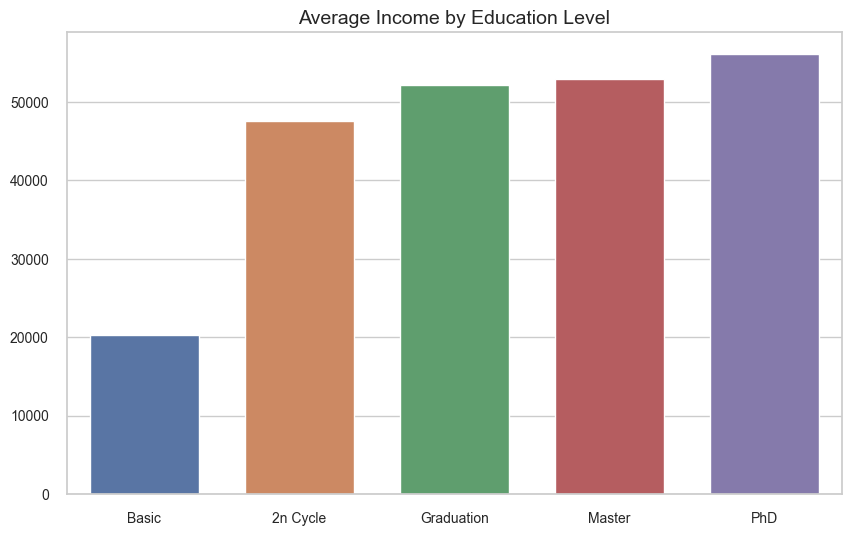

In [35]:
income_by_education = marketing_df.groupby('Education')['Income'].mean()
income_by_education = income_by_education.sort_values(ascending=True)

plt.figure(figsize=(10, 6))
sns.barplot(x=income_by_education.index, y=income_by_education.values, width=0.7)

plt.title("Average Income by Education Level", fontsize=14)
plt.xlabel("")
plt.ylabel("")

plt.tick_params(axis='y', labelsize=10)
plt.tick_params(axis='x', labelsize=10)
plt.show()

<Figure size 1000x600 with 0 Axes>

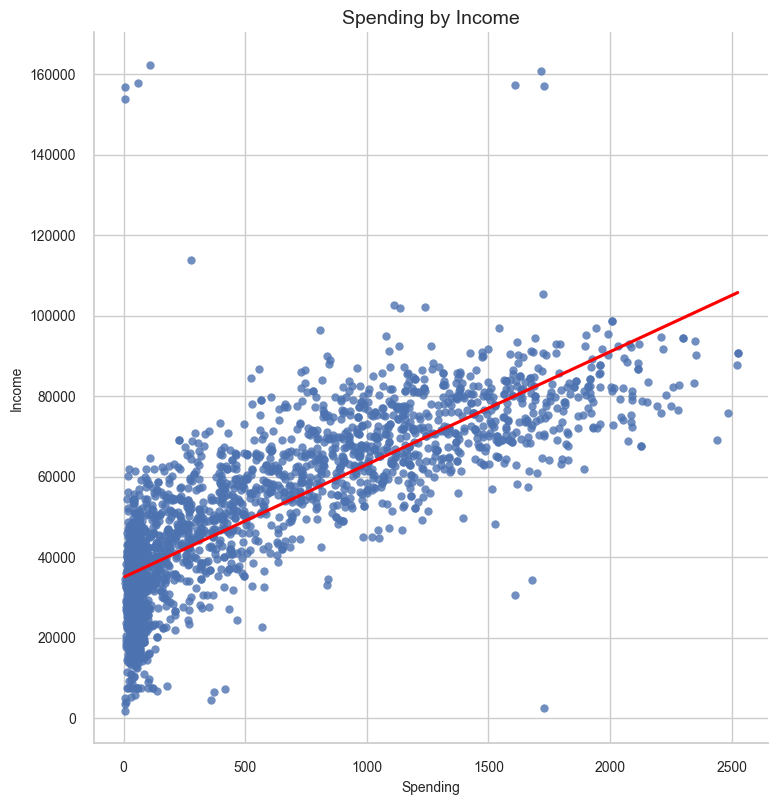

In [36]:
plt.figure(figsize=(10, 6))

sns.lmplot(data=marketing_df, x='Total_Spending', y='Income', ci=None, line_kws={'color': 'red'}, height=8)

plt.xlabel("Spending", fontsize=10)
plt.ylabel("Income", fontsize=10)
plt.title("Spending by Income", fontsize=14)

plt.tick_params(axis='y', labelsize=10)
plt.tick_params(axis='x', labelsize=10)

plt.show()

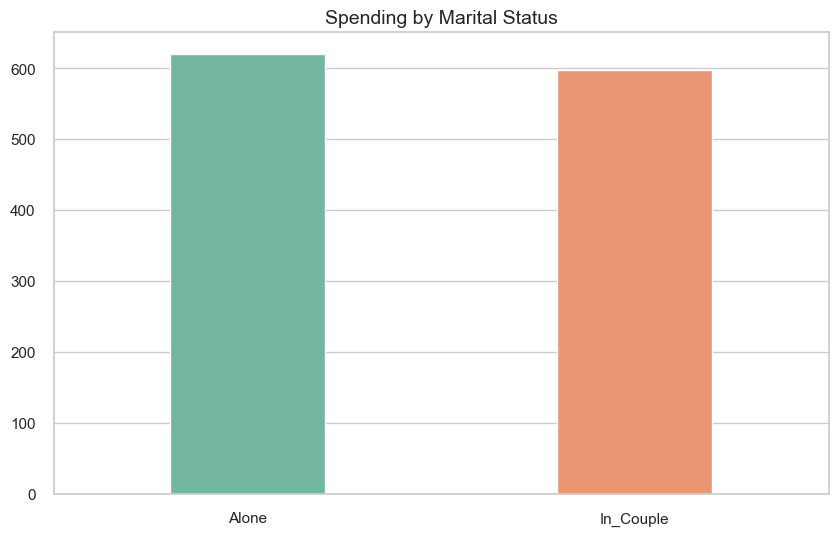

In [37]:
plt.figure(figsize=(10, 6))
sns.barplot(data=marketing_df, x='Marital_Situation', y='Total_Spending', ci=None, palette="Set2", width=0.4)

plt.xlabel("")
plt.ylabel("")
plt.title("Spending by Marital Status", fontsize=14)

plt.show()

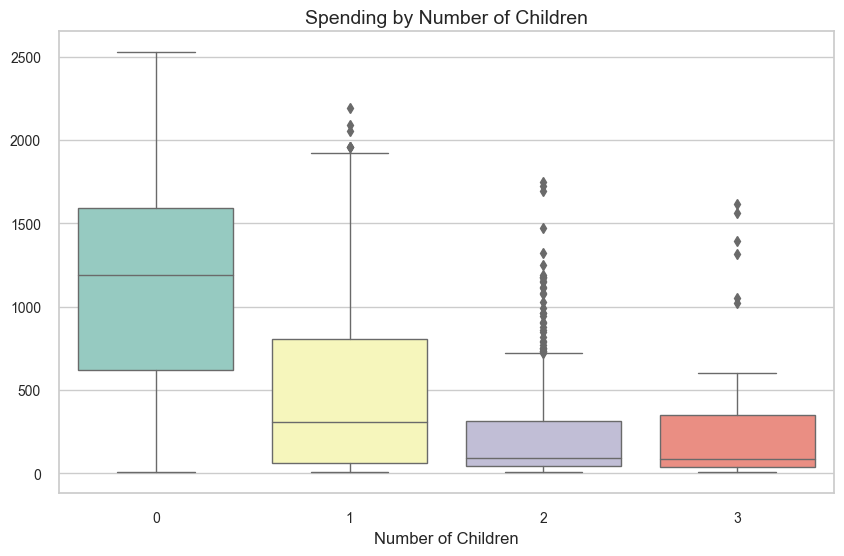

In [38]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=marketing_df, x='Total_Children', y='Total_Spending', palette="Set3", linewidth=1)

plt.xlabel("Number of Children")
plt.ylabel("")
plt.title("Spending by Number of Children", fontsize=14)

plt.tick_params(axis='y', labelsize=10)
plt.tick_params(axis='x', labelsize=10)

plt.show()

### 2.2. Correlations

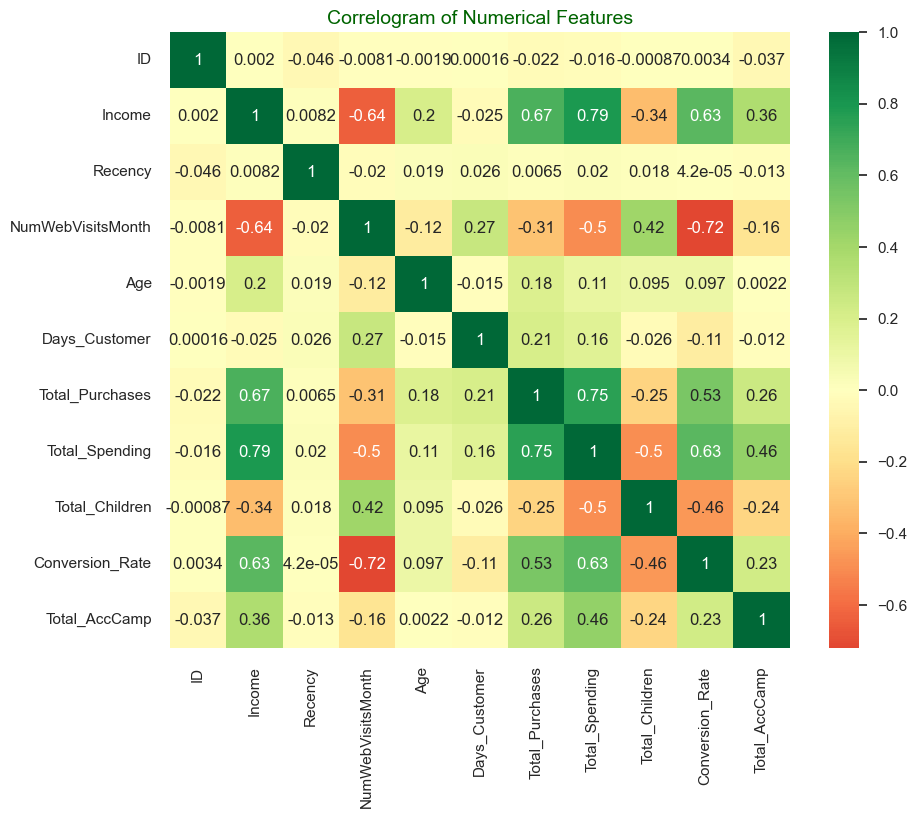

In [39]:
# Quantify correlations between features
plt.figure(figsize = (10, 8))

correlation_matrix = marketing_df[num_columns].corr()
sns.heatmap(correlation_matrix, cmap='RdYlGn', annot = True, center = 0)

plt.title('Correlogram of Numerical Features', fontsize = 14, color = 'darkgreen')

plt.show()

Correlation does not imply causation, and these correlations provide insights into the relationships between features but do not indicate direct causal relationships.
- There is a strong positive correlation of 0.79 between "Income" and "Total_spending", indicating that customers with higher incomes tend to spend more on products.
- "Total_spending" and "Total_purchases" are positively correlated with a correlation coefficient of 0.75. This suggests that customers who make more purchases also tend to spend more.
- The number of children a customer has "Total_Children" is negatively correlated with "Total_spending", suggesting that customers with more children tend to spend less.
- There is a positive correlation of 0.63 between "Conversion_rate" and "Income", suggesting that customers with higher incomes tend to have higher conversion rates.

# 4. Modeling and Data Analysis

## 4.1. Feature Selection

- R: Recency
- P: Total_Purchases
- S: Total_Spending
- I: Income
- C: Total_AccCamp

In [40]:
select_df = marketing_df[['Recency', 'Total_Purchases', 'Total_Spending', 'Income', 'Total_AccCamp']]
select_df.columns = ['R', 'P', 'S', 'I', 'C']

select_df.describe()

,R,P,S,I,C
count,2232.00,2232.00,2232.00,2232.00,2232.00
mean,49.15,14.86,605.62,51952.89,0.30
std,28.95,7.68,602.12,21444.07,0.68
min,0.00,0.00,5.00,1730.00,0.00
25%,24.00,8.00,69.00,35376.00,0.00
50%,49.50,15.00,396.00,51445.50,0.00
75%,74.00,21.00,1044.25,68275.75,0.00
max,99.00,44.00,2525.00,162397.00,4.00


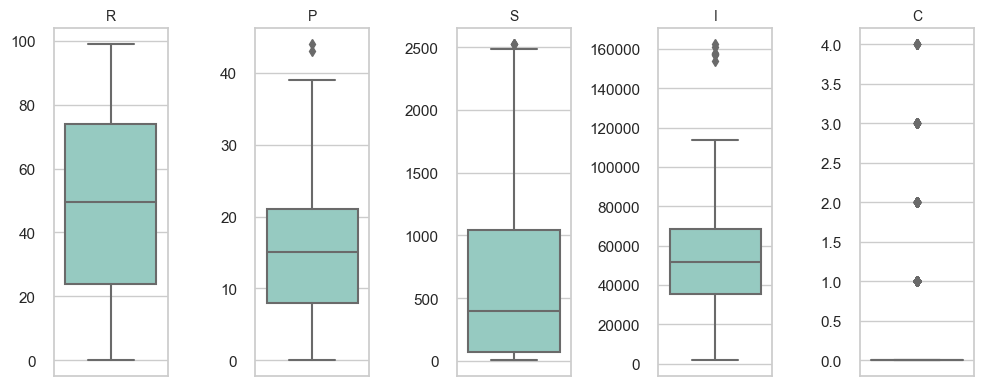

In [41]:
cols = select_df.columns

plt.figure(figsize= (10,15))

for i in range(len(cols)):
    plt.subplot(4, 5, i+1)
    sns.boxplot(y = select_df[cols[i]], orient='v', palette="Set3")
    plt.title(cols[i], fontsize=10)
    plt.gca().set(ylabel='')
    plt.tight_layout()

plt.show()    

In [42]:
for col in cols:
    high_cut = select_df[col].quantile(q=0.99)
    low_cut= select_df[col].quantile(q=0.01)
    select_df.loc[select_df[col]>high_cut, col] = high_cut
    select_df.loc[select_df[col]<low_cut, col] = low_cut

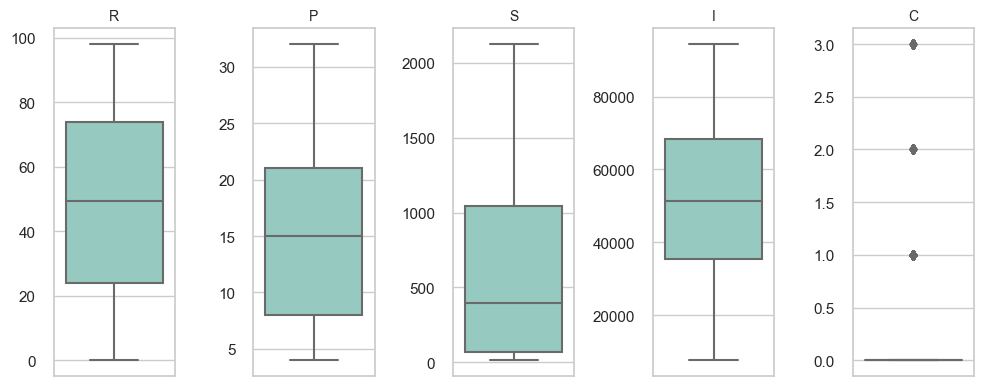

In [43]:
plt.figure(figsize= (10,15))

for i in range(len(cols)):
    plt.subplot(4, 5, i+1)
    sns.boxplot(y = select_df[cols[i]], orient='v', palette="Set3")
    plt.title(cols[i], fontsize=10)
    plt.gca().set(ylabel='')
    plt.tight_layout()

plt.show() 

In [44]:
select_df.describe()

,R,P,S,I,C
count,2232.00,2232.00,2232.00,2232.00,2232.00
mean,49.15,14.86,603.89,51735.83,0.29
std,28.94,7.60,597.21,20630.81,0.65
min,0.00,4.00,13.00,7663.68,0.00
25%,24.00,8.00,69.00,35376.00,0.00
50%,49.50,15.00,396.00,51445.50,0.00
75%,74.00,21.00,1044.25,68275.75,0.00
max,98.00,32.00,2126.00,94384.00,3.00


<Figure size 1000x1500 with 0 Axes>

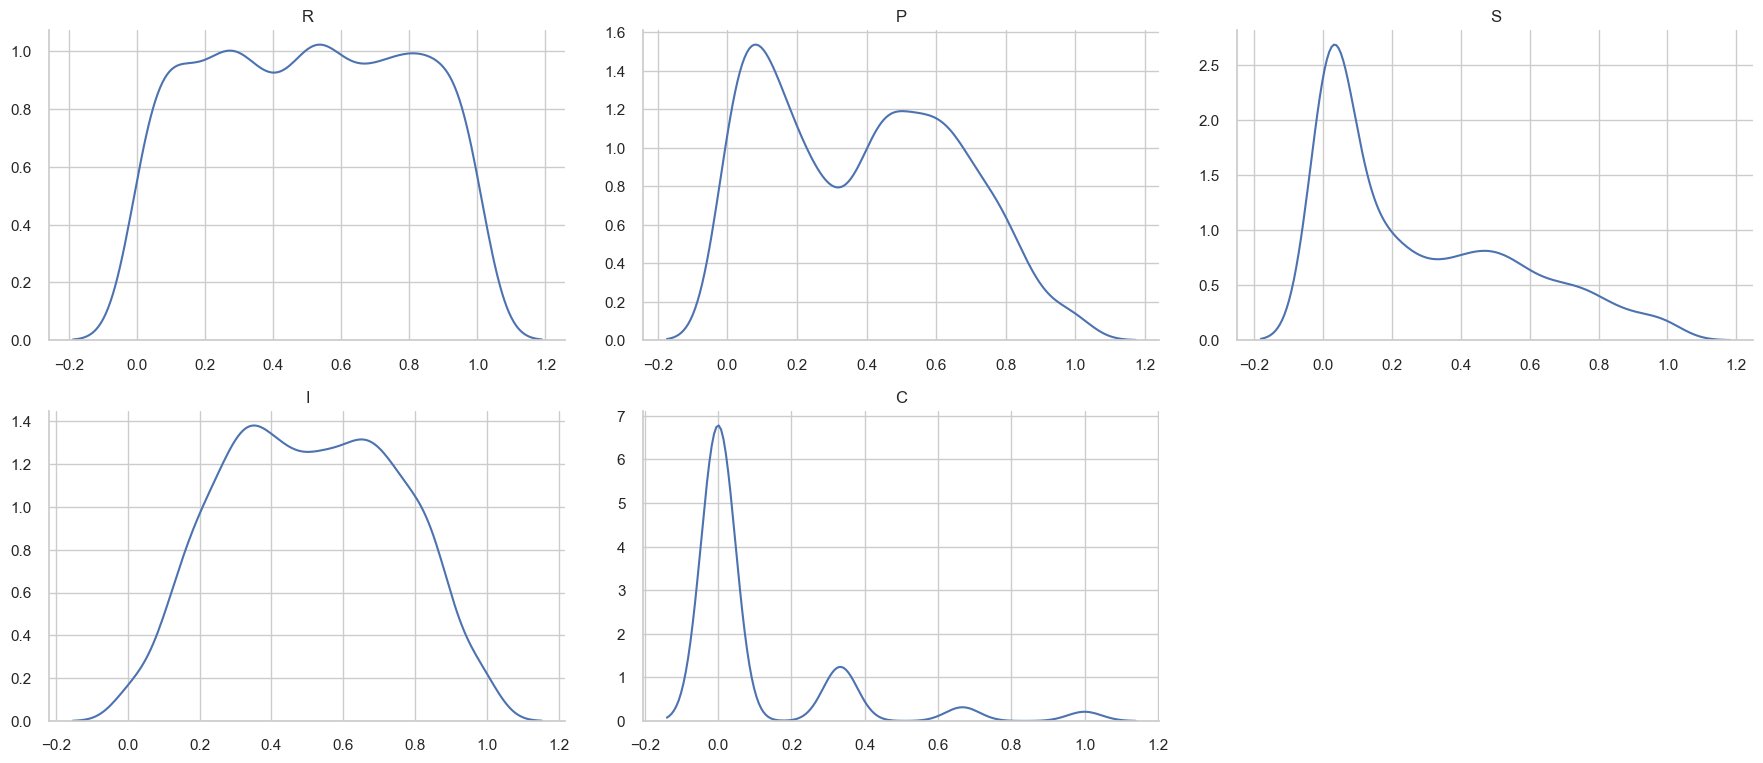

In [45]:
plt.figure(figsize= (10, 15))

scaler = MinMaxScaler()
select_df_scaled = scaler.fit_transform(select_df)

select_df_scaled = pd.DataFrame(select_df_scaled, columns=select_df.columns)

fig = sns.FacetGrid(select_df_scaled.melt(), col='variable', col_wrap=3, sharex=False, sharey=False, height=4, aspect=1.5)
fig.map(sns.kdeplot, 'value')

fig.set_titles(col_template="{col_name}")
fig.set_axis_labels("", "")

plt.show()

## 4.2. Elbow Score

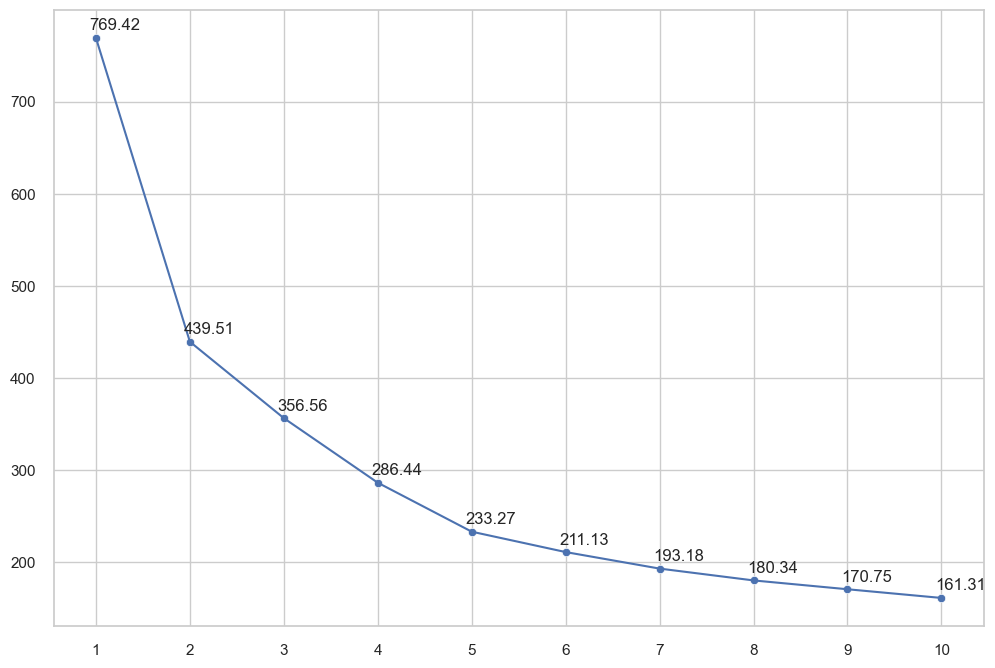

In [46]:
inertia=[]

for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=0)
    kmeans.fit(select_df_scaled)
    inertia.append(np.round(kmeans.inertia_ ,2))

x = range(1,11)
    
plt.figure(figsize=(12,8))
sns.lineplot(x=x, y=inertia)    
sns.scatterplot(x=x, y=inertia)

for i, label in enumerate(inertia):
    plt.text(x[i] + 0.2, inertia[i] + 5, label, ha='center', va='bottom')
    
plt.xticks(range(1,11 ,1))
plt.show()

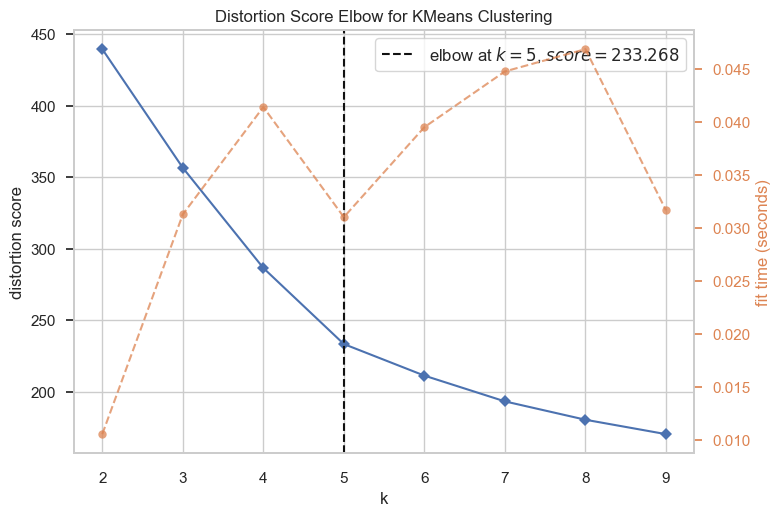

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [47]:
kmeans_yellowbrick = KMeans()
graph = KElbowVisualizer(kmeans_yellowbrick, k = (2, 10))
graph.fit(select_df_scaled)
graph.poof()

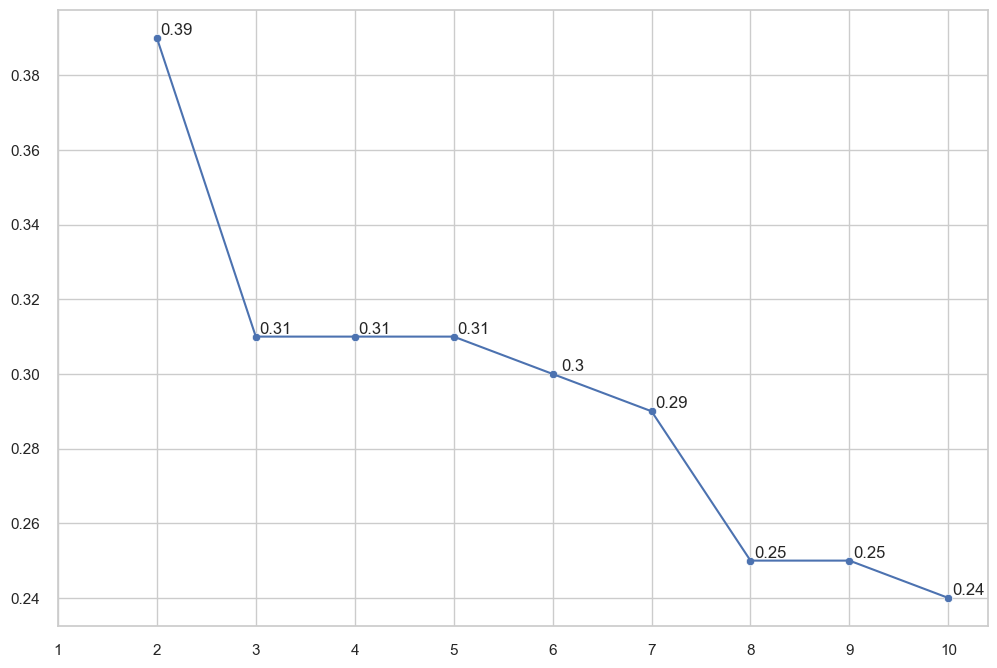

In [48]:
arr_silhouette_score = []

for i in range(2,11):
    kmeans = KMeans(n_clusters=i).fit(select_df_scaled)
    preds = kmeans.predict(select_df_scaled)
    score_euclidean = silhouette_score(select_df_scaled, preds, metric='euclidean')
    arr_silhouette_score.append(np.round(score_euclidean ,2))
    
x = range(2,11)
    
plt.figure(figsize=(12,8))
sns.lineplot(x=x, y=arr_silhouette_score)    
sns.scatterplot(x=x, y=arr_silhouette_score)

for i, label in enumerate(arr_silhouette_score):
    plt.text(x[i] + 0.2, arr_silhouette_score[i], label, ha='center', va='bottom')
    
plt.xticks(range(1,11 ,1))
plt.show()

In [49]:
model = KMeans(n_clusters=5, random_state=0).fit(select_df_scaled)

select_df_scaled['Cluster'] = model.labels_
marketing_df['Cluster'] = model.labels_

## 4.3. PCA

In [50]:
pca_df = select_df_scaled.drop(columns = 'Cluster')

In [51]:
pca = PCA(n_components=2)
pca.fit(pca_df)
pca_x = pca.transform(pca_df)

In [52]:
pca_df = pd.DataFrame(data = pca_x, columns = ['pc_1', 'pc_2'])
pca_df['Cluster'] = model.labels_
pca_df.sample(10)

,pc_1,pc_2,Cluster
692,-0.24,-0.46,3
1974,-0.34,0.48,0
1466,0.52,0.21,4
1795,0.22,-0.48,2
2131,-0.10,0.20,0
1577,-0.51,0.18,0
840,-0.44,-0.28,3
674,0.12,-0.26,2
2045,0.38,0.05,4
677,0.32,-0.02,2


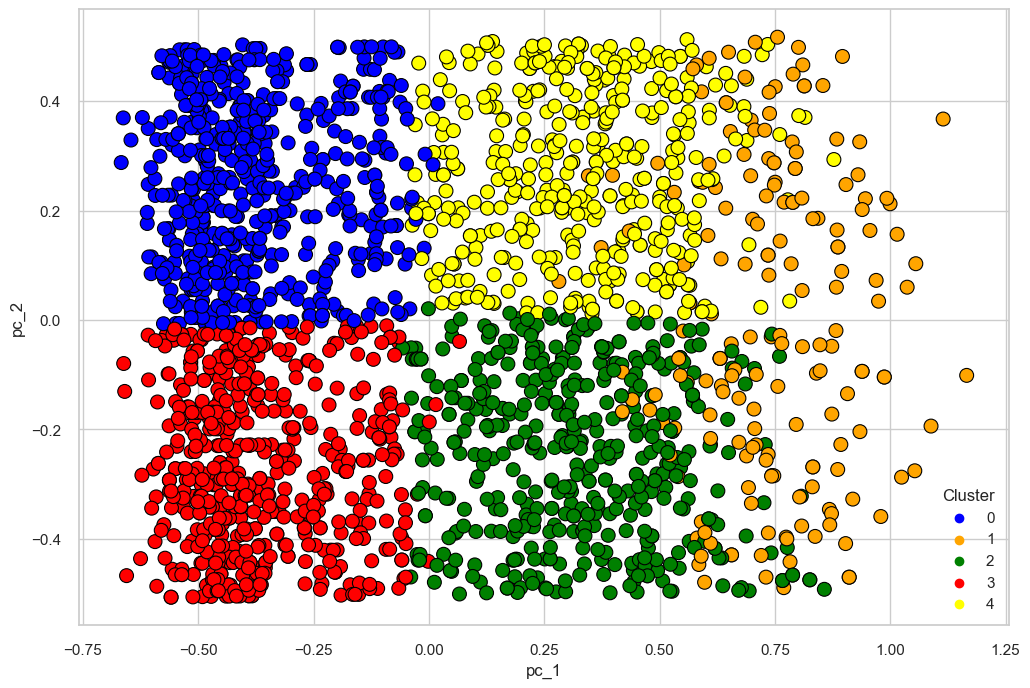

In [53]:
fig, ax = plt.subplots(figsize=(12,8))

sns.scatterplot(
    x="pc_1", y="pc_2",
    hue="Cluster",
    edgecolor='black',
    data=pca_df,
    palette=['blue','orange','green','red', 'yellow'],
    s=100,
    ax=ax
);

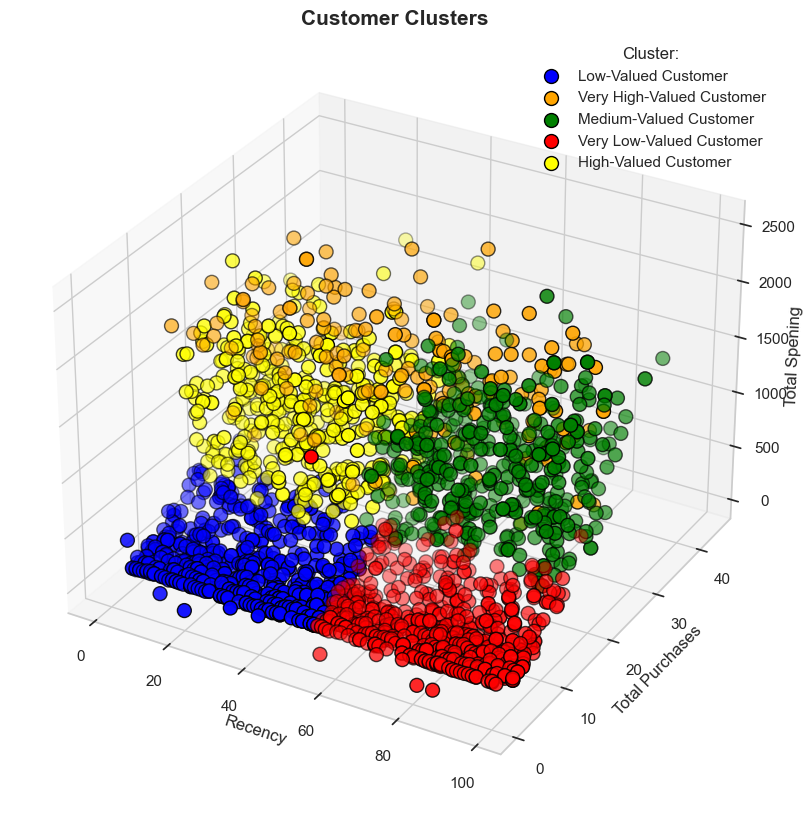

In [54]:
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111, projection='3d')
plt.title("Customer Clusters", fontsize=15, weight='bold')

ax.scatter(marketing_df['Recency'][marketing_df.Cluster == 0], marketing_df['Total_Purchases'][marketing_df.Cluster == 0], marketing_df['Total_Spending'][marketing_df.Cluster == 0], c='blue', s=100, edgecolor='black', label='Low-Valued Customer')
ax.scatter(marketing_df['Recency'][marketing_df.Cluster == 1], marketing_df['Total_Purchases'][marketing_df.Cluster == 1], marketing_df['Total_Spending'][marketing_df.Cluster == 1], c='orange', s=100, edgecolor='black', label='Very High-Valued Customer')
ax.scatter(marketing_df['Recency'][marketing_df.Cluster == 2], marketing_df['Total_Purchases'][marketing_df.Cluster == 2], marketing_df['Total_Spending'][marketing_df.Cluster == 2], c='green', s=100, edgecolor='black', label='Medium-Valued Customer')
ax.scatter(marketing_df['Recency'][marketing_df.Cluster == 3], marketing_df['Total_Purchases'][marketing_df.Cluster == 3], marketing_df['Total_Spending'][marketing_df.Cluster == 3], c='red', s=100, edgecolor='black', label='Very Low-Valued Customer')
ax.scatter(marketing_df['Recency'][marketing_df.Cluster == 4], marketing_df['Total_Purchases'][marketing_df.Cluster == 4], marketing_df['Total_Spending'][marketing_df.Cluster == 4], c='yellow', s=100, edgecolor='black', label='High-Valued Customer')

plt.xlabel('Recency')
plt.ylabel('Total Purchases')
ax.set_zlabel('Total Spening')
plt.legend(title='Cluster:')

plt.show()

In [55]:
cluster = []

for i in marketing_df['Cluster']:
    if i == 0:
        group = 'Low Value Customer'
    elif i == 1:
        group = 'Very High Value Customer'
    elif i == 2:
        group = 'Medium Value Customer'
    elif i == 3:
        group = 'Very Low Value Customer'        
    else :
        group = 'High Value Customer'
    cluster.append(group)
    
marketing_df['Cluster'] = cluster

In [56]:
ins_columns = ['Income', 'Recency', 'Age', 'Total_Purchases', 'Total_Spending', 'Total_Children',  'Cluster']

marketing_df[ins_columns].describe()

,Income,Recency,Age,Total_Purchases,Total_Spending,Total_Children
count,2232.00,2232.00,2232.00,2232.00,2232.00,2232.00
mean,51952.89,49.15,54.11,14.86,605.62,0.95
std,21444.07,28.95,11.70,7.68,602.12,0.75
min,1730.00,0.00,27.00,0.00,5.00,0.00
25%,35376.00,24.00,46.00,8.00,69.00,0.00
50%,51445.50,49.50,53.00,15.00,396.00,1.00
75%,68275.75,74.00,64.00,21.00,1044.25,1.00
max,162397.00,99.00,83.00,44.00,2525.00,3.00


In [57]:
marketing_df[ins_columns].groupby('Cluster').agg(['mean','median', 'max', 'min'])

Income                             Recency         \
                             mean   median       max      min    mean median   
Cluster                                                                        
High Value Customer      66635.42 66731.00 160803.00  2447.00   22.93  23.00   
Low Value Customer       36146.81 35788.00 162397.00  4023.00   24.33  24.00   
Medium Value Customer    66008.83 65747.50 157243.00 34445.00   73.25  72.00   
Very High Value Customer 80147.90 81246.00 105471.00 30576.60   50.61  54.00   
Very Low Value Customer  36251.22 36075.00 156924.00  1730.00   74.77  76.00   

                                   Age                Total_Purchases         \
                         max min  mean median max min            mean median   
Cluster                                                                        
High Value Customer       49   0 56.28  57.00  79  28           21.88  21.00   
Low Value Customer        49   0 51.76  51.00  78  27            8.59   8.00   
Medium Value Customer     99  47 56.85  57.00  80  29           21.23  21.00   
Very High Value Customer  99   1 53.91  53.00  82  28           21.32  21.00   
Very Low Value Customer   99  50 52.72  52.00  83  27            8.66   8.00   

                                 Total_Spending                     \
                         max min           mean  median   max  min   
Cluster                                                              
High Value Customer       44  11        1009.43  982.00  2092  277   
Low Value Customer        25   0         123.93   69.00   711    6   
Medium Value Customer     39  11        1004.64  971.50  2440  312   
Very High Value Customer  32  10        1647.12 1686.00  2525  416   
Very Low Value Customer   25   0         123.99   74.00  1679    5   

                         Total_Children                 
                                   mean median max min  
Cluster                                                 
High Value Customer                0.74   1.00   3   0  
Low Value Customer                 1.20   1.00   3   0  
Medium Value Customer              0.75   1.00   3   0  
Very High Value Customer           0.27   0.00   3   0  
Very Low Value Customer            1.25   1.00   3   0

In [58]:
age_cluster_df = marketing_df.groupby(['Cluster'])['Age'].count().reset_index()
age_cluster_df.rename(columns = {'Age' : 'Total Customer'}, inplace=True)
age_cluster_df['Percentage'] = np.round(age_cluster_df['Total Customer'] / age_cluster_df['Total Customer'].sum() * 100, 2)
age_cluster_df

,Cluster,Total Customer,Percentage
0,High Value Customer,425,19.04
1,Low Value Customer,593,26.57
2,Medium Value Customer,470,21.06
3,Very High Value Customer,187,8.38
4,Very Low Value Customer,557,24.96


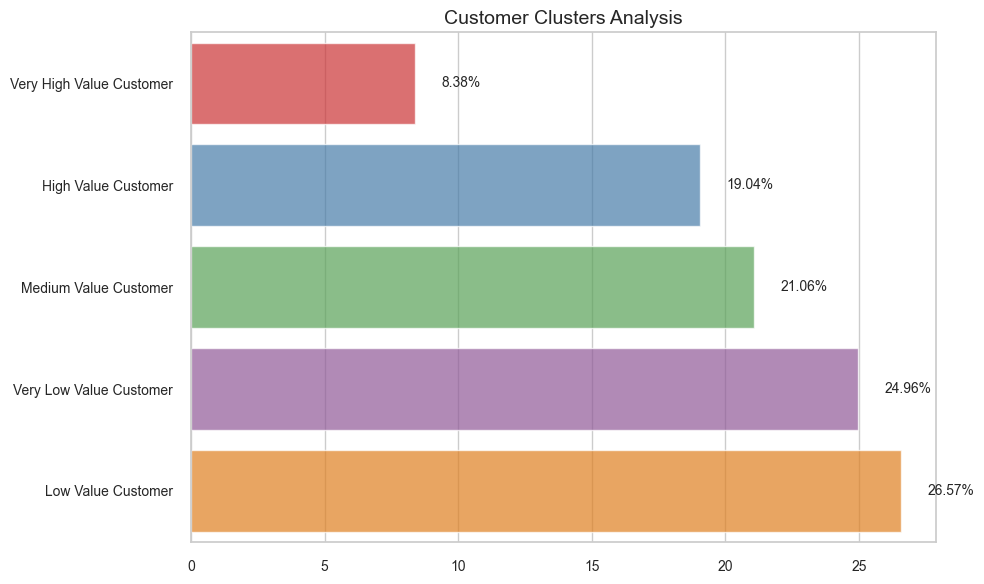

In [59]:
plt.figure(figsize=(10, 6))

age_cluster_df = age_cluster_df.sort_values(by='Percentage', ascending=True)

sns.barplot(data=age_cluster_df, x='Percentage', y='Cluster', palette="Set1", alpha=0.7)

for i, percentage in enumerate(age_cluster_df['Percentage']):
    plt.text(percentage + 1, i, f"{percentage:.2f}%", va='center', fontsize=10)

plt.title("Customer Clusters Analysis", fontsize=14)
plt.xlabel("")
plt.ylabel("")

plt.tick_params(axis='y', labelsize=10)
plt.tick_params(axis='x', labelsize=10)

plt.tight_layout()
plt.show()

- Customers with higher incomes are more likely to spend more.
- Very High Value and High Value Customers have made more recent purchases. They might be more responsive to marketing campaigns and offers. High and Very High Value Customers could be the primary targets for special offers and loyalty programs to enhance their engagement further.
- Very High Value Customers are older, which might imply a higher level of financial stability and purchasing power. Younger customers, represented by Low Value and Very Low Value Customers, tend to spend less.
- Very Low Value Customers have more children on average, which could impact their spending behavior. This might suggest a potential market segment for family-oriented products or services.

- Each cluster's unique characteristics and distribution highlight the need for segment-specific marketing campaigns. Personalized offers, loyalty programs, and communication can be tailored to address the preferences and behaviors of each group.
- Focusing on retaining High Value, Medium Value, and Very High Value Customers is essential. Their higher recency and spending habits indicate their engagement potential, making them valuable targets for retention efforts.
- While the Low Value and Very Low Value Customers together form a significant portion of the customer base, they might have untapped potential. Developing strategies to convert these segments into higher-value customers can yield long-term benefits.